In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.isnull().sum()

Passengers    0
dtype: int64

In [7]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


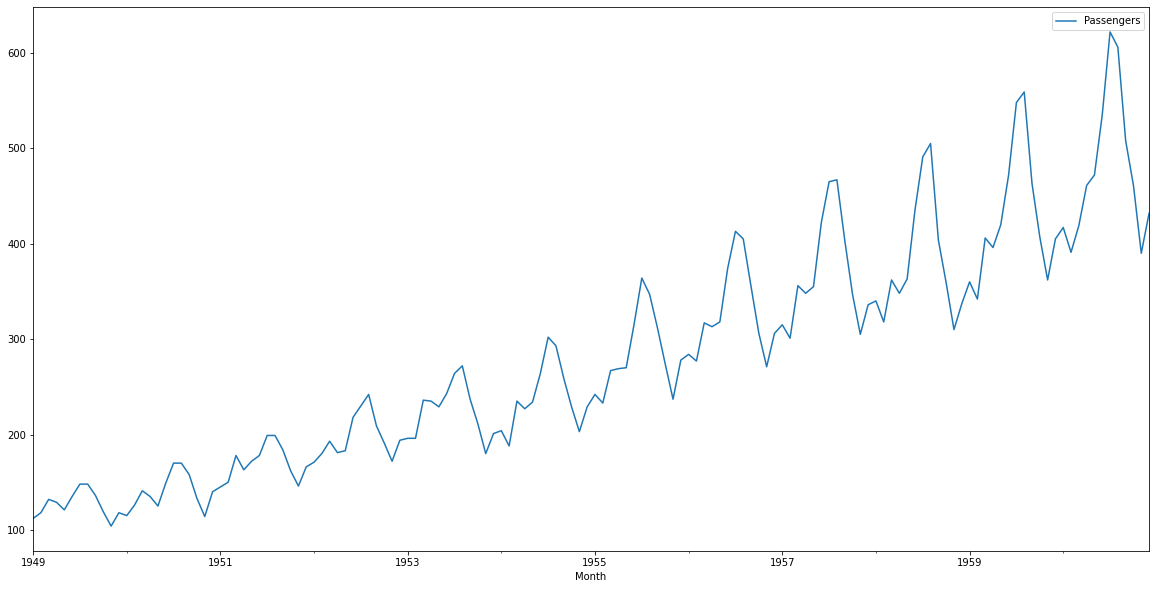

In [5]:
df.plot(figsize=(20, 10));

### EWMA

In [43]:
alpha = 0.618

Коэффициен альфа это гиперпараметр. Чем он ближе к 1, тем больший вес отдается самым последним значениям. И наборот.
При значении 1, EWMA=Price

In [44]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

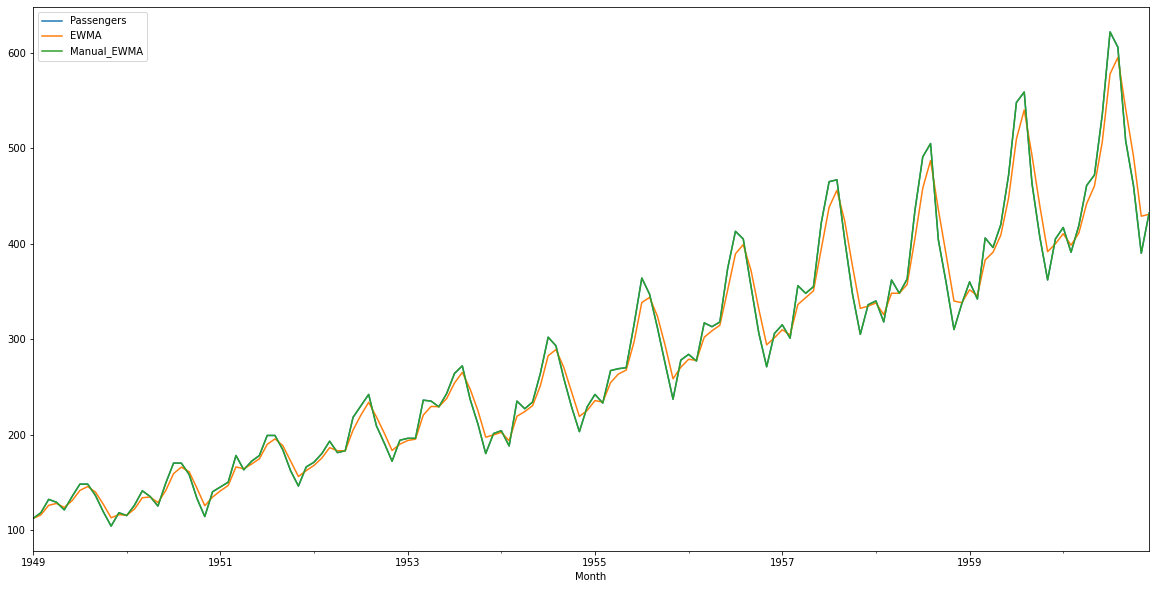

In [45]:
df.plot(figsize=(20, 10));

In [46]:
df

,Passengers,EWMA,Manual_EWMA
Month,,,
1949-01-01,112,112.000000,112
1949-02-01,118,115.708000,118
1949-03-01,132,125.776456,132
1949-04-01,129,127.768606,129
1949-05-01,121,123.585608,121
...,...,...,...
1960-08-01,606,595.265042,606
1960-09-01,508,541.335246,508
1960-10-01,461,491.688064,461


### Manual EWMA
Ручной расчет

In [52]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0: # проверка что это не первое значение
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x # вообще начальные значения инициируются нулями обычно, но тут мувинг был бы очень далеко от начальной цены
    manual_ewma.append(xhat)

df['Manual_EWMA'] = manual_ewma

In [53]:
df

,Passengers,EWMA,Manual_EWMA
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,115.708000,115.708000
1949-03-01,132,125.776456,125.776456
1949-04-01,129,127.768606,127.768606
1949-05-01,121,123.585608,123.585608
...,...,...,...
1960-08-01,606,595.265042,595.265042
1960-09-01,508,541.335246,541.335246
1960-10-01,461,491.688064,491.688064


In [55]:
df.drop(columns='Manual_EWMA', inplace=True)